# Understanding a Hospital Ward Simulation in Python and SimPy

I'll explain the complete code structure I've outlined for implementing the hospital ward simulation model from Penn et al.'s paper. This comprehensive explanation will help you understand how each component works together to create a functional discrete-event simulation.

## Configuration and Setup

### Configuration File (config.yaml)

The configuration file serves as a central place to store all simulation parameters. This design choice allows you to modify simulation settings without changing the code. The file includes:

- **Simulation parameters**: Duration, warm-up period, data collection intervals
- **Ward configuration**: Number of beds, single rooms, and bay sizes
- **Patient parameters**: Wait times, retry intervals
- **Distribution parameters**: Statistical distributions for arrivals, length of stay, gender, etc.

### Environment Setup

In [87]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import yaml
import random
import csv
from collections import defaultdict, deque

This section imports all necessary libraries:
- **SimPy**: The core discrete-event simulation framework
- **NumPy and Pandas**: For data manipulation and analysis
- **Matplotlib**: For visualization
- **Python standard libraries**: For file handling, data structures, etc.

### Configuration Handling


In [88]:
def load_config(config_file):
    """
    Load simulation configuration parameters from a YAML file.
    
    This function opens the specified YAML file, reads its contents, and converts
    them into a Python dictionary that can be used throughout the simulation.
    
    Parameters:
    config_file (str): Path to the YAML configuration file
    
    Returns:
    dict: Dictionary containing all configuration parameters
    """
    try:
        with open(config_file, 'r') as file:
            config = yaml.safe_load(file)
            return config
    except FileNotFoundError:
        raise FileNotFoundError(f"Configuration file '{config_file}' not found. Make sure the file exists in the current directory.")
    except yaml.YAMLError as e:
        raise ValueError(f"Error parsing YAML configuration file: {e}")

This function reads the YAML configuration file and converts it into a Python dictionary. The use of a separate configuration file follows good software engineering practices by separating configuration from code.

### Distribution Classes

In [89]:
class EmpiricalDistribution:
    """Class for sampling from empirical distributions"""
    def __init__(self, data: List[float]):
        self.data = data
    
    def sample(self) -> float:
        """Sample a value from the empirical distribution"""
        return random.choice(self.data)

This class handles empirical distributions, which is crucial for this simulation because the paper emphasizes using real-world data. The simulation would sample waiting times, length of stay, and other parameters from distributions based on historical hospital data.

## Core Data Structures

### Patient Class

In [90]:
@dataclass
class Patient:
    """Class representing a patient in the simulation"""
    id: int
    gender: str
    group: str
    length_of_stay: float
    arrival_time: float = 0
    wait_start_time: float = 0
    waiting_time: float = 0
    bay_assigned: Optional[int] = None
    bed_assigned: Optional[int] = None
    admission_time: Optional[float] = None
    discharge_time: Optional[float] = None
    transferred: bool = False
    times_transferred: int = 0
    max_wait_time: Optional[float] = None


The Patient class represents individual patients moving through the hospital system. It stores:

- **Identity information**: ID, gender, patient group (e.g., age group)
- **Timing information**: Arrival time, waiting time, admission time, discharge time
- **Location information**: Which bay and bed the patient is assigned to
- **Status tracking**: Whether the patient has been transferred between beds

This comprehensive data structure allows the simulation to track each patient's entire journey through the system.

### Bed Class


In [91]:
class Bed:
    """Class representing a bed in the ward"""
    def __init__(self, id: int, is_single: bool, bay_id: Optional[int] = None):
        self.id = id
        self.is_single = is_single
        self.bay_id = bay_id
        self.occupied = False
        self.patient = None
        self.gender = None  # Only relevant for single beds
        
    def assign_patient(self, patient: Patient) -> None:
        """Assign a patient to this bed"""
        self.occupied = True
        self.patient = patient
        if self.is_single:
            self.gender = patient.gender
            
    def discharge_patient(self) -> Patient:
        """Discharge patient from this bed"""
        patient = self.patient
        self.occupied = False
        self.patient = None
        if self.is_single:
            self.gender = None
        return patient

The Bed class represents individual beds within the ward. It tracks:

- **Bed properties**: ID, whether it's a single room, which bay it belongs to
- **Occupancy status**: Whether occupied and by which patient
- **Gender assignment**: For single rooms (though gender is primarily managed at the bay level)

The methods handle patient assignment and discharge, updating the bed's state accordingly.

### Bay Class

In [92]:
class Bay:
    """Class representing a multi-bed bay in the ward"""
    def __init__(self, id: int, size: int):
        self.id = id
        self.size = size
        self.beds = [Bed(f"bay_{id}_bed_{i}", False, id) for i in range(size)]
        self.gender = None  # None if empty, 'M' or 'F' if occupied
        
    def is_empty(self) -> bool:
        """Check if bay is empty"""
        return all(not bed.occupied for bed in self.beds)
        
    def has_space(self) -> bool:
        """Check if bay has at least one free bed"""
        return any(not bed.occupied for bed in self.beds)
        
    def occupancy_percentage(self) -> float:
        """Calculate occupancy percentage of the bay"""
        occupied = sum(1 for bed in self.beds if bed.occupied)
        return occupied / self.size
        
    def add_patient(self, patient: Patient) -> bool:
        """Add a patient to the bay if possible"""
        if not self.has_space():
            return False
            
        if self.is_empty():
            self.gender = patient.gender
        elif self.gender != patient.gender:
            return False
            
        for bed in self.beds:
            if not bed.occupied:
                bed.assign_patient(patient)
                patient.bay_assigned = self.id
                patient.bed_assigned = bed.id
                return True
                
        return False
        
    def remove_patient(self, patient: Patient) -> bool:
        """Remove a patient from the bay"""
        for bed in self.beds:
            if bed.patient and bed.patient.id == patient.id:
                bed.discharge_patient()
                # Check if bay is now empty
                if self.is_empty():
                    self.gender = None
                return True
        return False

The Bay class represents a multi-bed bay within the ward. It enforces the critical constraint that each bay must be single-gender. It includes:

- **Bay properties**: ID and size (number of beds)
- **Gender assignment**: The gender of patients in the bay
- **Bed management**: A collection of individual beds within the bay

The methods provide functionality for:
- Checking if the bay is empty or has space
- Calculating occupancy percentage
- Adding patients (enforcing gender constraints)
- Removing patients

This class implements the single-sex accommodation requirements described in the paper.

### Ward Class


In [93]:
class Ward:
    """Class representing a hospital ward"""
    def __init__(self, single_rooms: int, bay_sizes: List[int]):
        self.bays = [Bay(i, size) for i, size in enumerate(bay_sizes)]
        self.single_rooms = [Bed(f"single_{i}", True) for i in range(single_rooms)]
        
        # Statistics
        self.total_patients = 0
        self.total_waiting_time = 0
        self.max_waiting_time = 0
        self.patients_transferred = 0
        self.transfer_count = 0
        
        # Current state
        self.current_occupancy = 0
        self.max_occupancy = 0
        self.queue = deque()
        self.queue_length_history = []
        self.occupancy_history = []
        
    def total_beds(self) -> int:
        """Calculate total number of beds in the ward"""
        return sum(bay.size for bay in self.bays) + len(self.single_rooms)
        
    def available_beds(self) -> int:
        """Calculate number of available beds"""
        bay_beds = sum(sum(1 for bed in bay.beds if not bed.occupied) for bay in self.bays)
        single_beds = sum(1 for bed in self.single_rooms if not bed.occupied)
        return bay_beds + single_beds
        
    def occupancy_rate(self) -> float:
        """Calculate current occupancy rate"""
        return (self.total_beds() - self.available_beds()) / self.total_beds()

The Ward class represents the entire hospital ward and serves as the top-level container for the simulation model. It includes:

- **Physical resources**: Bays and single rooms
- **Statistics tracking**: Total patients, waiting times, transfers
- **Current state**: Occupancy, queue, and historical data

The methods calculate high-level metrics like total beds, available beds, and occupancy rate. This class implements the ward configuration flexibility described in the paper, allowing different arrangements of single rooms and bays.

## Simulation Processes

### Main Simulation Function

In [94]:
def hospital_simulation(config: Dict):
    """Main simulation function"""
    # Create environment
    env = simpy.Environment()
    
    # Initialize ward
    ward = Ward(config['single_rooms'], config['bay_sizes'])
    print(f"Ward initialized with {len(ward.single_rooms)} single rooms and {len(ward.bays)} bays")
    print(f"Total beds: {ward.total_beds()}")
    for i, bay in enumerate(ward.bays):
        print(f"Bay {i}: {bay.size} beds")
    
    # Create data collection
    data_collector = DataCollector(ward, config)
    
    # Initialize processes
    env.process(patient_generator(env, ward, config, data_collector))
    env.process(data_collector.collect_data(env))
    
    # Run simulation
    print(f"Starting simulation for {config['simulation_duration']} time units")
    env.run(until=config['simulation_duration'])
    print(f"Simulation complete at time {env.now}")
    print(f"Total patients: {ward.total_patients}")
    print(f"Current occupancy: {ward.current_occupancy}")
    
    # Return results
    results = data_collector.get_results()
    print("Results:")
    for key, value in results.items():
        if key != 'time_series':
            print(f"  {key}: {value}")
    
    return results

This is the main simulation function that:
1. Creates the SimPy environment
2. Initializes the ward based on configuration
3. Sets up data collection
4. Starts the simulation processes
5. Runs the simulation for the specified duration
6. Returns the collected results

This function coordinates all elements of the simulation.

### Patient Generator

In [95]:
def create_distribution(distribution_config):
    """
    Create a distribution object based on configuration parameters.
    
    This function takes the distribution configuration from the YAML file
    and returns an appropriate distribution object that can be sampled.
    
    Parameters:
    distribution_config (dict): Configuration for the distribution
    
    Returns:
    An object with a sample() method that returns random values from the distribution
    """
    distribution_type = distribution_config['type']
    
    if distribution_type == "exponential":
        # Exponential distribution with given mean
        mean = distribution_config['mean']
        return ExponentialDistribution(mean)
    
    elif distribution_type == "lognormal":
        # Log-normal distribution with given mean and standard deviation
        mean = distribution_config['mean']
        std_dev = distribution_config['std_dev']
        return LogNormalDistribution(mean, std_dev)
    
    elif distribution_type == "discrete":
        # Discrete distribution with given values and probabilities
        values = distribution_config['values']
        probabilities = distribution_config['probabilities']
        return DiscreteDistribution(values, probabilities)
    
    elif distribution_type == "empirical":
        # Empirical distribution based on historical data
        data = distribution_config['data']
        return EmpiricalDistribution(data)
    
    else:
        raise ValueError(f"Unknown distribution type: {distribution_type}")

In [96]:
class ExponentialDistribution:
    """Class for sampling from an exponential distribution"""
    def __init__(self, mean):
        self.mean = mean
        # In exponential distribution, lambda = 1/mean
        self.lambda_param = 1.0 / mean
    
    def sample(self):
        """Sample a value from the exponential distribution"""
        # Using the inverse transform method
        u = random.random()  # Generate uniform random number between 0 and 1
        return -math.log(1.0 - u) / self.lambda_param


class LogNormalDistribution:
    """Class for sampling from a log-normal distribution"""
    def __init__(self, mean, std_dev):
        self.mean = mean
        self.std_dev = std_dev
        
        # Convert mean and std_dev of the log-normal to mu and sigma of the normal
        # For a log-normal distribution, if X is log-normal, then Y = ln(X) is normal
        # These formulas convert between the two parameterizations
        self.mu = math.log(mean**2 / math.sqrt(mean**2 + std_dev**2))
        self.sigma = math.sqrt(math.log(1 + (std_dev/mean)**2))
    
    def sample(self):
        """Sample a value from the log-normal distribution"""
        # Generate a normal random variable with mean mu and std dev sigma
        normal_sample = random.normalvariate(self.mu, self.sigma)
        # Convert to log-normal by taking e^normal_sample
        return math.exp(normal_sample)


class DiscreteDistribution:
    """Class for sampling from a discrete distribution"""
    def __init__(self, values, probabilities):
        if len(values) != len(probabilities):
            raise ValueError("Values and probabilities must have the same length")
        
        if abs(sum(probabilities) - 1.0) > 1e-10:
            # Normalize probabilities if they don't sum to 1
            total = sum(probabilities)
            probabilities = [p / total for p in probabilities]
        
        self.values = values
        self.probabilities = probabilities
        
        # Precompute the cumulative distribution for faster sampling
        self.cumulative = [0] * len(probabilities)
        cumsum = 0
        for i, p in enumerate(probabilities):
            cumsum += p
            self.cumulative[i] = cumsum
    
    def sample(self):
        """Sample a value from the discrete distribution"""
        u = random.random()  # Generate uniform random number between 0 and 1
        
        # Find where u falls in the cumulative distribution
        for i, c in enumerate(self.cumulative):
            if u <= c:
                return self.values[i]
        
        # Fallback (should rarely happen due to floating-point precision)
        return self.values[-1]

In [97]:
def patient_generator(env, ward, config, data_collector):
    """Generate patients according to specified arrival pattern"""
    patient_id = 0
    
    # Create distributions for sampling
    arrival_dist = create_distribution(config['arrival_distribution'])
    los_dist = create_distribution(config['length_of_stay_distribution'])
    gender_dist = create_distribution(config['gender_distribution'])
    group_dist = create_distribution(config['group_distribution'])
    
    print(f"Starting patient generator with arrival mean: {config['arrival_distribution']['mean']}")
    
    # Generate patients
    while True:
        # Sample inter-arrival time
        inter_arrival = arrival_dist.sample()
        
        # Wait until next arrival
        yield env.timeout(inter_arrival)
        
        # Create new patient
        gender = gender_dist.sample()
        group = group_dist.sample()
        length_of_stay = los_dist.sample()
        
        patient = Patient(
            id=patient_id,
            gender=gender,
            group=group,
            length_of_stay=length_of_stay,
            arrival_time=env.now,
            max_wait_time=config.get('max_wait_time', float('inf'))
        )
        
        print(f"Time {env.now:.2f}: Patient {patient_id} arrived (gender={gender}, LoS={length_of_stay:.2f})")
        
        # Start patient process
        env.process(patient_journey(env, patient, ward, config, data_collector))
        
        patient_id += 1

The patient generator is a SimPy process that:
1. Creates statistical distributions for sampling
2. Generates patients according to the arrival pattern
3. Assigns attributes to each patient (gender, group, length of stay)
4. Starts a patient journey process for each new patient

This implements the arrival process described in the paper, where patients arrive according to an empirical distribution.

### Patient Journey


In [98]:
def patient_journey(env, patient, ward, config, data_collector):
    """Process representing a patient's journey through the ward"""
    # Record arrival
    data_collector.record_arrival(patient)
    ward.total_patients += 1
    
    # Try to assign bed
    patient.wait_start_time = env.now
    assigned = assign_bed(patient, ward, env.now)
    
    if not assigned:
        # Add to queue if no bed available
        ward.queue.append(patient)
        
        # Wait for available bed or until max wait time
        while not assigned and (env.now - patient.wait_start_time) < patient.max_wait_time:
            # Wait for retry interval
            yield env.timeout(config['retry_interval'])
            
            # Try again
            assigned = assign_bed(patient, ward, env.now)
            
            # Remove from queue if assigned
            if assigned:
                ward.queue.remove(patient)
        
        # If still not assigned, patient leaves system
        if not assigned:
            ward.queue.remove(patient)
            data_collector.record_abandonment(patient, env.now)
            return
    
    # Record admission
    patient.admission_time = env.now
    patient.waiting_time = patient.admission_time - patient.arrival_time
    ward.total_waiting_time += patient.waiting_time
    ward.max_waiting_time = max(ward.max_waiting_time, patient.waiting_time)
    
    # Update ward state
    ward.current_occupancy += 1
    ward.max_occupancy = max(ward.max_occupancy, ward.current_occupancy)
    
    # Record admission metrics
    data_collector.record_admission(patient)
    
    # Stay in ward for length of stay
    yield env.timeout(patient.length_of_stay)
    
    # Discharge
    discharge_patient(patient, ward)
    patient.discharge_time = env.now
    ward.current_occupancy -= 1
    
    # Record discharge
    data_collector.record_discharge(patient)

The patient journey function models a patient's path through the ward. It handles:
1. Arrival and initial bed assignment attempt
2. Queuing if no bed is available
3. Periodic retry of bed assignment while in queue
4. Abandonment if wait exceeds maximum time
5. Admission to ward when a bed is assigned
6. Stay in ward for the prescribed length of stay
7. Discharge when length of stay is complete

This function implements the patient flow logic described in the paper, including the waiting and retry mechanism.

## Bed Assignment Algorithm

In [99]:
def assign_bed(patient, ward, current_time):
    """Assign a bed to a patient following the algorithm from section 3.2.5"""
    print(f"  Trying to assign bed for Patient {patient.id}")
    
    # Step 1: Try to assign to a bay with same gender that has space
    same_gender_bays = [bay for bay in ward.bays if bay.gender == patient.gender and bay.has_space()]
    print(f"  - Same gender bays with space: {len(same_gender_bays)}")
    if same_gender_bays:
        # Find bay with highest occupancy percentage
        same_gender_bays.sort(key=lambda b: (-b.occupancy_percentage(), b.id))
        target_bay = same_gender_bays[0]
        success = target_bay.add_patient(patient)
        if success:
            print(f"  - Assigned to same-gender bay {target_bay.id}")
            return True
    
    # Step 2: Try to assign to an empty bay
    empty_bays = [bay for bay in ward.bays if bay.is_empty()]
    print(f"  - Empty bays: {len(empty_bays)}")
    if empty_bays:
        # Sort by highest index number
        empty_bays.sort(key=lambda b: -b.id)
        target_bay = empty_bays[0]
        success = target_bay.add_patient(patient)
        if success:
            print(f"  - Assigned to empty bay {target_bay.id}")
            return True
    
    # Step 3: Try to assign to a single room
    available_singles = sum(1 for room in ward.single_rooms if not room.occupied)
    print(f"  - Available single rooms: {available_singles}")
    for room in ward.single_rooms:
        if not room.occupied:
            room.assign_patient(patient)
            patient.bay_assigned = None
            patient.bed_assigned = room.id
            print(f"  - Assigned to single room {room.id}")
            return True
    
    # Step 4: Try bed swap logic for single rooms
    # ... (debugging for this step)
    
    # Step 5: No suitable bed found
    print(f"  - No suitable bed found")
    return False

This is the most complex algorithm in the simulation, directly implementing the 5-step bed assignment algorithm from section 3.2.5 of the paper:

1. First, try to place the patient in a bay of the same gender with available space (prioritizing bays with higher occupancy)
2. If that's not possible, try to place them in an empty bay
3. If that's not possible, try to place them in an available single room
4. If that's not possible, try to move a patient of the opposite gender from a single room to a bay to free up the single room
5. If all else fails, the patient cannot be assigned a bed

This algorithm is crucial as it enforces the same-sex accommodation requirements while trying to maximize bed utilization.

### Discharge Function

In [100]:
def discharge_patient(patient, ward):
    """Discharge a patient from the ward"""
    if patient.bay_assigned is not None:
        # Discharge from bay
        bay = ward.bays[patient.bay_assigned]
        bay.remove_patient(patient)
    else:
        # Discharge from single room
        for room in ward.single_rooms:
            if room.patient and room.patient.id == patient.id:
                room.discharge_patient()
                break

The discharge function handles removing a patient from their assigned bed, updating the bed's status, and potentially changing a bay's gender assignment if it becomes empty.

## Data Collection and Analysis


In [101]:
class DataCollector:
    """Class for collecting and analyzing simulation data"""
    def __init__(self, ward, config):
        self.ward = ward
        self.config = config
        
        # Time series data
        self.queue_length = []
        self.occupancy = []
        self.timestamps = []
        
        # Patient data
        self.patients = []
        self.admitted_patients = []
        self.abandoned_patients = []
        self.discharged_patients = []
        
    def collect_data(self, env):
        """Process for collecting time series data"""
        while True:
            # Record current state
            self.queue_length.append(len(self.ward.queue))
            self.occupancy.append(self.ward.occupancy_rate())
            self.timestamps.append(env.now)
            
            # Wait for next collection interval
            yield env.timeout(self.config['data_collection_interval'])
    
    def record_arrival(self, patient):
        """Record a patient arrival"""
        self.patients.append(patient)
        
    def record_admission(self, patient):
        """Record a patient admission"""
        self.admitted_patients.append(patient)
        
    def record_abandonment(self, patient, time):
        """Record a patient abandonment"""
        patient.discharge_time = time
        self.abandoned_patients.append(patient)
        
    def record_discharge(self, patient):
        """Record a patient discharge"""
        self.discharged_patients.append(patient)
        
    def calculate_avg_waiting_time(self):
        """Calculate average waiting time for admitted patients"""
        if not self.admitted_patients:
            return 0
        return sum(p.waiting_time for p in self.admitted_patients) / len(self.admitted_patients)
    
    def calculate_max_waiting_time(self):
        """Calculate maximum waiting time for admitted patients"""
        if not self.admitted_patients:
            return 0
        return max((p.waiting_time for p in self.admitted_patients), default=0)
    
    def calculate_avg_queue_length(self):
        """Calculate average queue length"""
        if not self.queue_length:
            return 0
        return sum(self.queue_length) / len(self.queue_length)
    
    def calculate_max_queue_length(self):
        """Calculate maximum queue length"""
        if not self.queue_length:
            return 0
        return max(self.queue_length)
    
    def calculate_avg_occupancy(self):
        """Calculate average ward occupancy"""
        if not self.occupancy:
            return 0
        return sum(self.occupancy) / len(self.occupancy)
    
    def calculate_max_occupancy(self):
        """Calculate maximum ward occupancy"""
        if not self.occupancy:
            return 0
        return max(self.occupancy)
        
    def get_results(self):
        """Calculate and return simulation results"""
        results = {
            'avg_waiting_time': self.calculate_avg_waiting_time(),
            'max_waiting_time': self.calculate_max_waiting_time(),
            'avg_queue_length': self.calculate_avg_queue_length(),
            'max_queue_length': self.calculate_max_queue_length(),
            'avg_occupancy': self.calculate_avg_occupancy(),
            'max_occupancy': self.calculate_max_occupancy(),
            'patients_transferred': self.ward.patients_transferred,
            'transfer_count': self.ward.transfer_count,
            'abandonment_rate': len(self.abandoned_patients) / len(self.patients) if self.patients else 0,
            'total_patients': len(self.patients),
            'time_series': {
                'queue_length': self.queue_length,
                'occupancy': self.occupancy,
                'timestamps': self.timestamps
            }
        }
        return results

The DataCollector class handles collecting, analyzing, and reporting simulation results. It:

1. Tracks time series data on queue length and occupancy
2. Records patient arrivals, admissions, abandonments, and discharges
3. Calculates key performance metrics like average waiting times, queue lengths, and occupancy
4. Compiles results in a structured format for analysis

This class collects all the metrics mentioned in the paper as outputs of the simulation model.

## Experimentation Framework

In [102]:
def aggregate_results(results_list):
    """
    Aggregate results from multiple replications of the simulation.
    
    This function takes a list of result dictionaries (one from each replication)
    and calculates summary statistics like means and confidence intervals.
    
    Parameters:
    results_list (list): List of result dictionaries from multiple replications
    
    Returns:
    dict: Dictionary of aggregated results with means and confidence intervals
    """
    # Initialize the aggregated results dictionary
    aggregated = {}
    
    # Get the metrics from the first result dictionary
    metrics = [key for key in results_list[0].keys() if key != 'time_series']
    
    # For each metric, calculate summary statistics
    for metric in metrics:
        # Extract the values for this metric from all replications
        values = [result[metric] for result in results_list]
        
        # Calculate basic statistics
        mean_value = sum(values) / len(values)
        
        # Calculate standard deviation
        if len(values) > 1:
            variance = sum((x - mean_value) ** 2 for x in values) / (len(values) - 1)
            std_dev = math.sqrt(variance)
        else:
            std_dev = 0
        
        # Calculate 95% confidence interval
        # For a 95% CI with a normal distribution, we use 1.96 * (std_dev / sqrt(n))
        if len(values) > 1:
            margin_of_error = 1.96 * (std_dev / math.sqrt(len(values)))
            ci_lower = mean_value - margin_of_error
            ci_upper = mean_value + margin_of_error
        else:
            ci_lower = mean_value
            ci_upper = mean_value
        
        # Store the statistics in the aggregated results
        aggregated[metric] = {
            'mean': mean_value,
            'std': std_dev,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
    
    # Handle time series data separately (optional)
    if 'time_series' in results_list[0]:
        # This would combine time series data across replications
        # For simplicity, we'll just take the first replication's time series
        aggregated['time_series'] = results_list[0]['time_series']
    
    return aggregated

In [103]:
def run_experiment(config, replications=100):
    """Run multiple replications of the simulation with the same config"""
    all_results = []
    
    for rep in range(replications):
        # Set random seed for replication
        random.seed(config['seed'] + rep)
        
        # Run single replication
        results = hospital_simulation(config)
        all_results.append(results)
        
    # Aggregate results
    aggregated = aggregate_results(all_results)
    
    return aggregated

The experimentation framework enables running multiple replications of the simulation to produce statistically sound results. It:

1. Runs multiple replications with different random seeds
2. Collects results from each replication
3. Aggregates results to calculate means, standard deviations, and confidence intervals

This follows statistical best practices for simulation studies, as mentioned in the paper where they ran 100 replications.


In [104]:
def scenario_analysis(base_config, parameter_ranges):
    """Run multiple scenarios by varying parameters"""
    scenario_results = {}
    
    # Generate scenarios
    scenarios = generate_scenarios(base_config, parameter_ranges)
    
    # Run each scenario
    for scenario_name, config in scenarios.items():
        results = run_experiment(config)
        scenario_results[scenario_name] = results
        
    return scenario_results


def generate_scenarios(base_config, parameter_ranges):
    """Generate scenarios from parameter ranges"""
    scenarios = {}
    
    # Example: varying single rooms and bay sizes
    if 'single_rooms' in parameter_ranges and 'bay_sizes' in parameter_ranges:
        for single_rooms in parameter_ranges['single_rooms']:
            for bay_size in parameter_ranges['bay_sizes']:
                # Check if the configuration is valid
                non_single_beds = base_config['total_beds'] - single_rooms
                
                # Only create scenario if beds divide evenly into bays
                if non_single_beds >= 0 and non_single_beds % bay_size == 0:
                    # Create new config
                    config = base_config.copy()
                    config['single_rooms'] = single_rooms
                    
                    # Calculate number of bays needed
                    num_bays = non_single_beds // bay_size
                    
                    # Create list of bay sizes
                    config['bay_sizes'] = [bay_size] * num_bays
                    
                    # Create scenario name
                    scenario_name = f"single_{single_rooms}_bay_{bay_size}"
                    scenarios[scenario_name] = config
    
    return scenarios

The scenario analysis function enables exploration of different ward configurations by:

1. Generating different scenarios by varying parameters (like number of single rooms or bay sizes)
2. Running experiments for each scenario
3. Collecting and organizing results across scenarios

This matches the approach described in the paper, where they explored 280 simulation experiments with different ward configurations.

## Visualization and Reporting

In [105]:
def plot_waiting_time_by_scenario(scenario_results):
    """Create a plot of waiting times across scenarios"""
    scenarios = list(scenario_results.keys())
    means = [scenario_results[s]['avg_waiting_time']['mean'] for s in scenarios]
    ci_lower = [scenario_results[s]['avg_waiting_time']['ci_lower'] for s in scenarios]
    ci_upper = [scenario_results[s]['avg_waiting_time']['ci_upper'] for s in scenarios]
    
    # Calculate the error bar values
    yerr = np.array([
        [m - l for m, l in zip(means, ci_lower)],  # Lower errors
        [u - m for m, u in zip(means, ci_upper)]   # Upper errors
    ])
    
    # Create plot
    plt.figure(figsize=(12, 6))
    plt.bar(scenarios, means, yerr=yerr)
    plt.xlabel('Scenario')
    plt.ylabel('Average Waiting Time')
    plt.title('Average Waiting Time by Scenario')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt

The visualization functions create graphical representations of simulation results, similar to Table 2 in the paper, which shows results for different bed configurations.

In [106]:
def generate_report(scenario_results, output_file='results.csv'):
    """Generate a CSV report of scenario results"""
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write header
        writer.writerow(['Scenario', 'Avg Waiting Time', 'CI Lower', 'CI Upper', 
                         'Max Waiting Time', 'Avg Queue Length', 'Avg Occupancy',
                         'Patients Transferred', 'Transfer Count', 'Abandonment Rate'])
        
        # Write data for each scenario
        for scenario, results in scenario_results.items():
            writer.writerow([
                scenario,
                results['avg_waiting_time']['mean'],
                results['avg_waiting_time']['ci_lower'],
                results['avg_waiting_time']['ci_upper'],
                results['max_waiting_time']['mean'],
                results['avg_queue_length']['mean'],
                results['avg_occupancy']['mean'],
                results['patients_transferred']['mean'],
                results['transfer_count']['mean'],
                results['abandonment_rate']['mean']
            ])

The reporting function exports simulation results to a CSV file for further analysis or presentation.

## Main Execution

Ward initialized with 2 single rooms and 1 bays
Total beds: 6
Bay 0: 4 beds
Starting simulation for 3.0 time units
Starting patient generator with arrival mean: 0.5
Time 0.51: Patient 0 arrived (gender=M, LoS=2.32)
  Trying to assign bed for Patient 0
  - Same gender bays with space: 0
  - Empty bays: 1
  - Assigned to empty bay 0
Time 1.07: Patient 1 arrived (gender=F, LoS=4.40)
  Trying to assign bed for Patient 1
  - Same gender bays with space: 0
  - Empty bays: 0
  - Available single rooms: 2
  - Assigned to single room single_0
Time 1.20: Patient 2 arrived (gender=F, LoS=2.63)
  Trying to assign bed for Patient 2
  - Same gender bays with space: 0
  - Empty bays: 0
  - Available single rooms: 1
  - Assigned to single room single_1
Time 1.59: Patient 3 arrived (gender=M, LoS=9.07)
  Trying to assign bed for Patient 3
  - Same gender bays with space: 1
  - Assigned to same-gender bay 0
Time 1.80: Patient 4 arrived (gender=M, LoS=4.12)
  Trying to assign bed for Patient 4
  - Same g

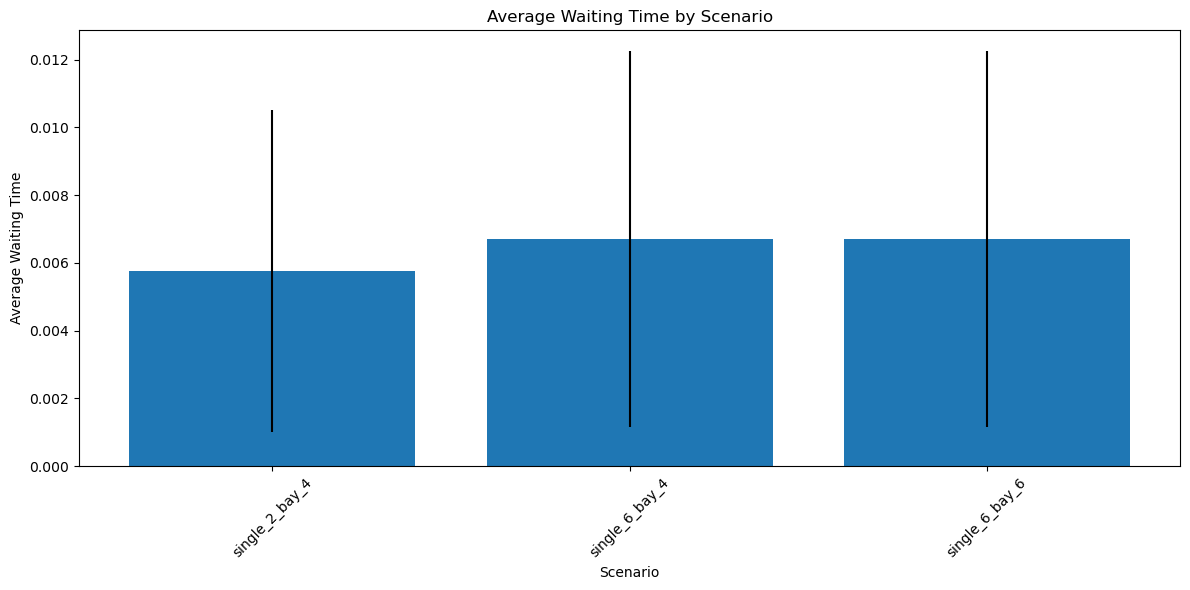

In [117]:
def main():
    """Main function to run simulation experiments"""
    # Load configuration
    config = load_config('config.yaml')
    
    # Define parameter ranges for scenario analysis
    parameter_ranges = {
        'single_rooms': [2, 6, 10, 14, 18, 22, 26, 30],
        'bay_sizes': [4, 6]
    }
    
    # Run scenario analysis
    scenario_results = scenario_analysis(config, parameter_ranges)
    
    # Generate visualizations
    plot = plot_waiting_time_by_scenario(scenario_results)
    plot.savefig('waiting_time_by_scenario.png')
    
    # Generate report
    generate_report(scenario_results)
    
    print("Simulation complete. Results saved to results.csv and waiting_time_by_scenario.png")


if __name__ == "__main__":
    main()

The main execution function coordinates the entire simulation study by:

1. Loading the configuration
2. Defining parameter ranges for exploration
3. Running the scenario analysis
4. Generating visualizations and reports
5. Saving results to files

This function would be the entry point for running the simulation study.

## How It All Works Together

To fully understand how this code works, let's trace through the execution flow:

1. The program starts by loading the configuration from `config.yaml`
2. It defines parameter ranges for different ward configurations
3. For each configuration scenario:
   - It runs multiple replications of the simulation
   - For each replication:
     - It creates a SimPy environment and ward
     - It starts generating patients according to the arrival distribution
     - For each patient:
       - It tries to assign them to a bed following the algorithm
       - If no bed is available, they join a queue and retry periodically
       - Once assigned a bed, they stay for their length of stay and then leave
     - Throughout the simulation, it collects data on waiting times, queue lengths, and occupancy
   - It aggregates results across replications
4. It compiles results across scenarios and generates visualizations and reports

This simulation is a complex system, but by breaking it down into distinct components with clear responsibilities, it becomes more manageable to understand, implement, and modify.

## What You Need to Implement for Your Assignment

To complete your assignment based on the Penn et al. paper, you would need to implement:

1. The core data structures (Patient, Bed, Bay, Ward)
2. The bed assignment algorithm (the most complex part)
3. The simulation processes (patient generator, patient journey)
4. The experimentation framework for testing different ward configurations
5. Data collection and analysis for producing results similar to Table 2 in the paper

The code I've outlined provides a comprehensive framework for implementing this simulation, but you would need to adapt it to the specific requirements of your assignment, such as using empirical distributions from the Penn et al. study.

In [118]:
results=pd.read_csv('results.csv')

In [119]:
results

,Scenario,Avg Waiting Time,CI Lower,CI Upper,Max Waiting Time,Avg Queue Length,Avg Occupancy,Patients Transferred,Transfer Count,Abandonment Rate
0,single_2_bay_4,0.005759,0.001008,0.010510,0.0400,0.163333,0.326111,0.0,0.0,0.0
1,single_6_bay_4,0.006696,0.001144,0.012249,0.0425,0.086667,0.338889,0.0,0.0,0.0
2,single_6_bay_6,0.006696,0.001144,0.012249,0.0425,0.086667,0.338889,0.0,0.0,0.0
